In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from numpy import cos
from math import log
from scipy.interpolate import interp1d
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize
from scipy.optimize import fsolve
from sympy import symbols, Eq, solve

In [2]:
T_linha = 25.6
T1= 26.4 
T2= 0.025
omega1= 0.017
phi1= -1.45

R1= 250.083 
R2= 0.565
omega2= 0.02
phi2=1.6

B_E=200
p_ME=0.9
p_ML=0.75
p_MP=0.85
tau_E=1
tau_P=1
# c1=0.019
# c2=-0.021
c1=0.00554
c2=-0.06737
mu_H = 0.00007

D1=36.5
b1=0.04

A=12.5
B=15
C=-48.78

b2=0.09
tau_H=10
DD=105
Tmin=14.5
gamma= 1/120 #365 
R_L = 450
N = 7717 #População estimada para 2004
M = 300000 
k=1 #Análise sem efeito do desmatamento

E_M0 = 1 #Analisando a infecção iniciando com apenas um mosquito exposto e um humano infectado
I_H0 = 1
I_M0 = 0
R_H0 = 0
if E_M0 is None:
        E_M0 = M / 100

S_H0 = N - I_H0 - R_H0
S_M0 = M - E_M0 - I_M0

In [3]:
def Temp(t):
    return T1 * (1 + T2 * cos(omega1 * t - phi1))

def Rain(t):
    return R1 * (1 + R2 * cos(omega2 * t - phi2))

R_final = Rain(1825)
T_final = Temp(1825)
    
# Duração da fase de desenvolvimento das larvas
def tau_L(Temp):
    return 1 / (c1 * Temp + c2)
    
# Taxa diária de sobrevivência dos mosquitos
def p(Temp):
    return np.exp(-1 / (A*Temp**2 + B*Temp + C))
    
# Probabilidade de sobrevivência das larvas dependente de temperatura e chuva
def p_LT(Temp):
    return np.exp(-(c1 * Temp + c2))
    
def p_LR(Rain):
    return (4*p_ML/R_L**2) * Rain * (max(10^-5,R_L - Rain))
    
def p_LRT(Rain,Temp):
    return p_LR(Rain)*p_LT(Temp)
    
# Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
def p_ER(Rain):
    return (4*p_ME/R_L**2) * Rain * (max(10^-5,R_L - Rain))
    
# Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
def p_PR(Rain):
    return (4*p_MP/R_L**2) * Rain * (max(10^-5,R_L - Rain))

# Duração do ciclo esporogônico
def tau_M(Temp):
    return DD / (max(10^-5,Temp - Tmin))
    
tau_M_final = tau_M(T_final)

# Taxa de infecção de expostos (1/Duração do ciclo esporogônico)
def b3(tau_M, Temp):
    return 1/tau_M
    
b3_final = b3(tau_M_final, T_final)
    
# Definindo a função de sobrevivência do mosquito
def l_tau_M(tau_M, Temp):  
    p_T = p(Temp)
    return p_T**tau_M
    
l_final = l_tau_M(tau_M_final, T_final)

# Definindo a taxa de mortalidade do mosquito
def mu(Temp):
    return -log(p(Temp))
    
mu_final = mu(T_final)
    
# Calcula a taxa de picada e probabilidade de transmissão
def a(Temp):
    return (max(10^-5, Temp - T_linha)) / D1
    
a_final = a(T_final)
    
def b(Rain,Temp):
    return B_E * p_ER(Rain) * p_LRT(Rain,Temp) * p_PR(Rain) / (tau_E + tau_L(Temp) + tau_P)
    
b_final = b(R_final, T_final)

In [4]:
def R0_sir(a, k, b2, gamma, mu_H):
    return abs((a * k * b2) / (gamma + mu_H))
    
#R0_sir_curr = R0_sir(a_curr, b2, gamma)
    
def R0_sei(a, k, b1, b3, l, mu):
    return abs((a * k * b1 * b3) / ((b3 + l) * mu + mu** 2))
    
#R0_sei_curr = R0_sei(a_curr, b1, b3_curr, l_curr, mu_curr)
    
def R0_full(a, k, b1, b2, b3, gamma, l, mu, mu_H):
    return abs(((a**2 * b1 * b2 * b3 * k**2) / (mu*(gamma + mu_H)*(b3 + l + mu)))**(1/2))
    
#R0_curr = R0(a_curr, b1, b2, b3_curr, gamma, l_curr, mu_curr)

def calculate_initial_values(R_L, T_linha, Tmin, DD, D1, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                            p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, gamma, mu_H, k):
    
    T0 = T1 * (1 + T2 * cos(omega1 * 0 - phi1))
    R0 = R1 * (1 + R2 * cos(omega2 * 0 - phi2))

    tau_L0 = 1 / (c1 * T0 + c2)

    p_LT0 = np.exp(-(c1 * T0 + c2))
    
    p_LR0 = (4 * p_ML / R_L**2) * R0 * (max(1e-5, R_L - R0))
    
    p_LRT0 = p_LR0 * p_LT0
    
    p_ER0 = (4 * p_ME / R_L**2) * R0 * (max(1e-5, R_L - R0))
    
    p_PR0 = (4 * p_MP / R_L**2) * R0 * (max(1e-5, R_L - R0))

    a0 = (max(1e-5, T0 - T_linha)) / D1
    b0 = B_E * p_ER0 * p_LRT0 * p_PR0 / (tau_E + tau_L0 + tau_P)

    tau_M0 = DD / (max(1e-5, T0 - Tmin))
    
    b30 =  1 / tau_M0
    
    p0 = np.exp(-1 / (A * T0**2 + B * T0 + C))
    l0 = p0 ** tau_M0

    mu0 = -log(p0)

    initial_R0_sir = R0_sir(a0, k, b2, gamma, mu_H)
    initial_R0_sei = R0_sei(a0, k, b1, b30, l0, mu0)
    initial_R0_full = R0_full(a0, k, b1, b2, b30, gamma, l0, mu0, mu_H)
    
    return initial_R0_sir, initial_R0_sei, initial_R0_full, a0

In [5]:
initial_R0_sir, initial_R0_sei, initial_R0_full, a0 = calculate_initial_values(R_L, T_linha, Tmin, DD, D1, 
                                                                               T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                               p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, 
                                                                               gamma, mu_H, k)

In [6]:
print(f'R0_sir = {initial_R0_sir} \nR0_sei = {initial_R0_sei}\nR0_acoplado = {initial_R0_full}\nTaxa de picadas = {a0}')

R0_sir = 0.258077185614824 
R0_sei = 0.9002047882569278
R0_acoplado = 0.4819982554225031
Taxa de picadas = 0.02409676240499894


In [7]:
initial_R0_sir, initial_R0_sei, initial_R0_full, a0 = calculate_initial_values(R_L, T_linha, Tmin, DD, D1, 
                                                                               T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                               p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, 
                                                                               gamma, mu_H, 10)

In [8]:
print(f'R0_sir = {initial_R0_sir} \nR0_sei = {initial_R0_sei}\nR0_acoplado = {initial_R0_full}\nTaxa de picadas = {a0}')

R0_sir = 2.5807718561482402 
R0_sei = 9.00204788256928
R0_acoplado = 4.819982554225031
Taxa de picadas = 0.02409676240499894


In [9]:
k_values = np.linspace(0, 10, 100) 

R0_full_values = []

for k_val in k_values:
    initial_R0_sir, initial_R0_sei, R0_full_val, a0_val = calculate_initial_values(R_L, T_linha, Tmin, DD, D1, 
                                                                               T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                               p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, 
                                                                               gamma, mu_H, k=k_val)
    R0_full_values.append(R0_full_val)

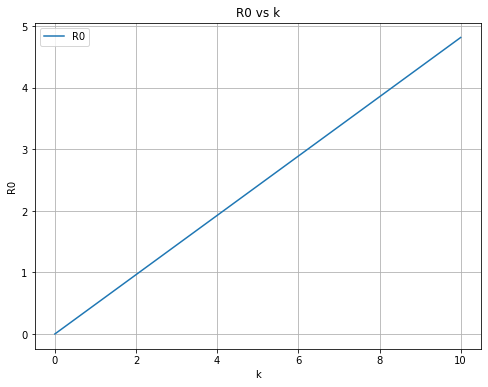

In [10]:
plt.figure(figsize=(8, 6))

plt.plot(k_values, R0_full_values, label='R0')
plt.xlabel('k')
plt.ylabel('R0')
plt.title('R0 vs k')

plt.legend()
plt.grid(True)

plt.show()  

In [11]:
initial_R0_sir, initial_R0_sei, initial_R0_full, a0 = calculate_initial_values(R_L, T_linha, Tmin, DD, D1, 
                                                                               T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                               p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, 
                                                                               gamma, mu_H, 2)

In [12]:
print(f'R0_sir = {initial_R0_sir} \nR0_sei = {initial_R0_sei}\nR0_acoplado = {initial_R0_full}\nTaxa de picadas = {a0}')

R0_sir = 0.516154371229648 
R0_sei = 1.8004095765138557
R0_acoplado = 0.9639965108450061
Taxa de picadas = 0.02409676240499894


In [13]:
initial_R0_sir, initial_R0_sei, initial_R0_full, a0 = calculate_initial_values(R_L, T_linha, Tmin, DD, D1, 
                                                                               T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                               p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, 
                                                                               gamma, mu_H, 2.1)

In [14]:
print(f'R0_sir = {initial_R0_sir} \nR0_sei = {initial_R0_sei}\nR0_acoplado = {initial_R0_full}\nTaxa de picadas = {a0}')

R0_sir = 0.5419620897911305 
R0_sei = 1.8904300553395483
R0_acoplado = 1.0121963363872564
Taxa de picadas = 0.02409676240499894


In [15]:
def equation_to_solve(k):
    initial_R0_full = calculate_initial_values(
        R_L, T_linha, Tmin, DD, D1, T1, T2,
        omega1, phi1, R1, R2, omega2, phi2,
        p_ML, p_ME, p_MP, c1, c2, A, B, C,
        b1, b2, gamma, mu_H, k)[2] ##índice de R0 completo em calculate_initial_values
    return initial_R0_full -1

# Use fsolve to find the root (solution)
initial_guess = 0.5  # Choose an initial guess for k
k_solution = fsolve(equation_to_solve, initial_guess)

print(f"O valor de k que aproxima R0 de 1 é {k_solution[0]}")

O valor de k que aproxima R0 de 1 é 2.0746963059512207


In [16]:
initial_R0_sir, initial_R0_sei, initial_R0_full, a0 = calculate_initial_values(R_L, T_linha, Tmin, DD, D1, 
                                                                               T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                               p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, 
                                                                               gamma, mu_H, 2.0746963059512207)

In [17]:
print(f'R0_sir = {initial_R0_sir} \nR0_sei = {initial_R0_sei}\nR0_acoplado = {initial_R0_full}\nTaxa de picadas = {a0}')

R0_sir = 0.535431783645363 
R0_sei = 1.8676515487962488
R0_acoplado = 1.0
Taxa de picadas = 0.02409676240499894


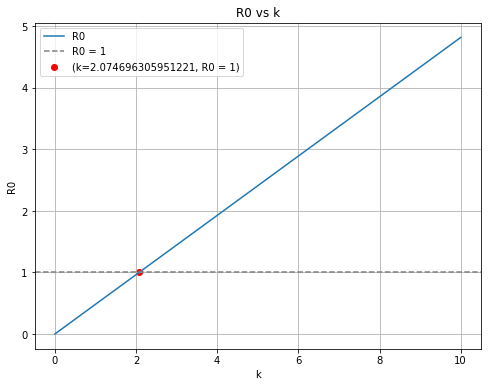

In [18]:
k_value_at_1 = 2.0746963059512207
R0_value_at_1 = 1

plt.figure(figsize=(8, 6))

plt.plot(k_values, R0_full_values, label='R0')
plt.scatter([k_value_at_1], [R0_value_at_1], color='red', label=f'(k={k_value_at_1}, R0 = {R0_value_at_1})')
plt.axhline(y=1, color='gray', linestyle='--', label='R0 = 1')
plt.xlabel('k')
plt.ylabel('R0')
plt.title('R0 vs k')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
def equilibrium_numerator(N, mu, b3, l, mu_H, a, b, b1, b2, k, gamma):
    return (N**2 * mu**3 + (N**2 * b3 + N**2 * l)*mu**2)*mu_H**2 - (N * a**2 * b * b1 * b2 * b3 * k**2 - N**2 * gamma * mu**3 - (N**2 * b3 * gamma + N**2 * gamma * l) * mu**2) * mu_H
     
    
def equilibrium_denominator(N, mu, b3, l, mu_H, a, b, b1, b2, k, gamma):
    return a**2 * b * b1 * b2 * b3 * gamma * k**2 + (N * a * b1 * k * mu**2 + (N * a * b1 * b3 * k + N * a * b1 * k * l)*mu)*mu_H**2 + (a**2 * b * b1 * b2 * b3 * k**2 + N * a * b1 * gamma * k * mu**2 + (N * a * b1 * b3 * gamma * k + N * a * b1 * gamma * k * l)*mu)*mu_H
    
    
def equilibrium(N, mu, b3, l, mu_H, a, b, b1, b2, k, gamma):
    return -1*equilibrium_numerator(N, mu, b3, l, mu_H, a, b, b1, b2, k, gamma) / equilibrium_denominator(N, mu, b3, l, mu_H, a, b, b1, b2, k, gamma)
    
def calculate_equilibrium_initial_values(N, R_L, T_linha, Tmin, DD, D1, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                            p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, gamma, mu_H, k):
    
    T0 = T1 * (1 + T2 * cos(omega1 * 0 - phi1))
    R0 = R1 * (1 + R2 * cos(omega2 * 0 - phi2))

    tau_L0 = 1 / (c1 * T0 + c2)

    p_LT0 = np.exp(-(c1 * T0 + c2))
    
    p_LR0 = (4 * p_ML / R_L**2) * R0 * (max(1e-5, R_L - R0))
    
    p_LRT0 = p_LR0 * p_LT0
    
    p_ER0 = (4 * p_ME / R_L**2) * R0 * (max(1e-5, R_L - R0))
    
    p_PR0 = (4 * p_MP / R_L**2) * R0 * (max(1e-5, R_L - R0))

    a0 = (max(1e-5, T0 - T_linha)) / D1
    b0 = B_E * p_ER0 * p_LRT0 * p_PR0 / (tau_E + tau_L0 + tau_P)

    tau_M0 = DD / (max(1e-5, T0 - Tmin))
    
    b30 =  1 / tau_M0
    
    p0 = np.exp(-1 / (A * T0**2 + B * T0 + C))
    l0 = p0 ** tau_M0

    mu0 = -log(p0)

    equilibrium_numerator_initial = equilibrium_numerator(N, mu0, b30, l0, mu_H, a0, b0, b1, b2, k, gamma)
    equilibrium_denominator_initial = equilibrium_denominator(N, mu0, b30, l0, mu_H, a0, b0, b1, b2, k, gamma)
    equilibrium_initial = equilibrium(N, mu0, b30, l0, mu_H, a0, b0, b1, b2, k, gamma)
    
    return equilibrium_numerator_initial, equilibrium_denominator_initial, equilibrium_initial

In [20]:
equilibrium_numerator_initial, equilibrium_denominator_initial, equilibrium_initial = calculate_equilibrium_initial_values(N, R_L, T_linha, Tmin, DD, D1, 
                                                                               T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                               p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, 
                                                                               gamma, mu_H, k)

In [21]:
print(f'I_H no equilíbrio em t=0: {equilibrium_initial}')

I_H no equilíbrio em t=0: 30.008876867379975


In [22]:
def calculate_equilibrium_final_values(N, R_L, T_linha, Tmin, DD, D1, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                            p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, gamma, mu_H, k):
    
    Tf = T1 * (1 + T2 * cos(omega1 * 1825 - phi1))
    Rf = R1 * (1 + R2 * cos(omega2 * 1825 - phi2))

    tau_Lf = 1 / (c1 * Tf + c2)

    p_LTf = np.exp(-(c1 * Tf + c2))
    
    p_LRf = (4 * p_ML / R_L**2) * Rf * (max(1e-5, R_L - Rf))
    
    p_LRTf = p_LRf * p_LTf
    
    p_ERf = (4 * p_ME / R_L**2) * Rf * (max(1e-5, R_L - Rf))
    
    p_PRf = (4 * p_MP / R_L**2) * Rf * (max(1e-5, R_L - Rf))

    af = (max(1e-5, Tf - T_linha)) / D1
    bf = B_E * p_ERf * p_LRTf * p_PRf / (tau_E + tau_Lf + tau_P)

    tau_Mf = DD / (max(1e-5, Tf - Tmin))
    
    b3f =  1 / tau_Mf
    
    pf = np.exp(-1 / (A * Tf**2 + B * Tf + C))
    lf = pf ** tau_Mf

    muf = -log(pf)

    equilibrium_numerator_final = equilibrium_numerator(N, muf, b3f, lf, mu_H, af, bf, b1, b2, k, gamma)
    equilibrium_denominator_final = equilibrium_denominator(N, muf, b3f, lf, mu_H, af, bf, b1, b2, k, gamma)
    equilibrium_final = equilibrium(N, muf, b3f, lf, mu_H, af, bf, b1, b2, k, gamma)
    
    return equilibrium_numerator_final, equilibrium_denominator_final, equilibrium_final

In [23]:
equilibrium_numerator_final, equilibrium_denominator_final, equilibrium_final = calculate_equilibrium_final_values(N, R_L, T_linha, Tmin, DD, D1, 
                                                                               T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                               p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, 
                                                                               gamma, mu_H, k)

In [24]:
print(f'I_H no equilíbrio em t=1825: {equilibrium_final}')

I_H no equilíbrio em t=1825: 22.326789550435866


In [25]:
k_values = np.linspace(0, 10, 100) 

equilibrium_full_values = []

for k_val in k_values:
    equilibrium_numerator_final, equilibrium_denominator_final, equilibrium_final = calculate_equilibrium_final_values(N, R_L, T_linha, Tmin, DD, D1, 
                                                                               T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                               p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, 
                                                                               gamma, mu_H, k=k_val)
    equilibrium_full_values.append(equilibrium_final)

/opt/sagemath-9.2/local/lib/python3.7/site-packages/sage/repl/ipython_kernel/__main__.py:10: RuntimeWarning: divide by zero encountered in double_scalars


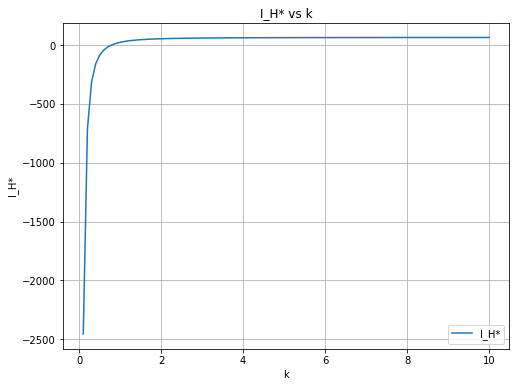

In [26]:
plt.figure(figsize=(8, 6))

plt.plot(k_values, equilibrium_full_values, label='I_H*')
plt.xlabel('k')
plt.ylabel('I_H*')
plt.title('I_H* vs k')

plt.legend()
plt.grid(True)

plt.show()  

In [27]:
def equation_to_solve_equilibrium(k):
    equilibrium_final = calculate_equilibrium_final_values(
        N, R_L, T_linha, Tmin, DD, D1, T1, T2,
        omega1, phi1, R1, R2, omega2, phi2,
        p_ML, p_ME, p_MP, c1, c2, A, B, C,
        b1, b2, gamma, mu_H, k)[2] ##índice do nequilíbrio completo em calculate_equilibrium_final_values
    return equilibrium_final

# Use fsolve to find the root (solution)
initial_guess = 0.5  # Choose an initial guess for k
k_solution = fsolve(equation_to_solve_equilibrium, initial_guess)

print(f"O valor de k que zera o equilíbrio é {k_solution[0]}")

O valor de k que zera o equilíbrio é 0.7948596924159165


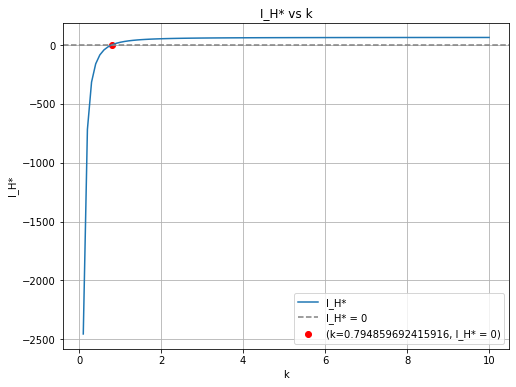

In [28]:
k_value_at_0 = 0.7948596924159165
equilibrium_value_at_0 = 0

plt.figure(figsize=(8, 6))

plt.plot(k_values, equilibrium_full_values, label='I_H*')
plt.scatter([k_value_at_0], [equilibrium_value_at_0], color='red', label=f'(k={k_value_at_0}, I_H* = {equilibrium_value_at_0})')
plt.axhline(y=0, color='gray', linestyle='--', label='I_H* = 0')
plt.xlabel('k')
plt.ylabel('I_H*')
plt.title('I_H* vs k')
plt.legend()
plt.grid(True)
plt.show()

Equilíbrio da população de infectados no com $k$ máximo:

In [29]:
equilibrium_numerator_final, equilibrium_denominator_final, equilibrium_final = calculate_equilibrium_final_values(N, R_L, T_linha, Tmin, DD, D1, 
                                                                               T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                               p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, 
                                                                               gamma, mu_H, 10)

In [30]:
print(f'I_H no equilíbrio em t=1825: {equilibrium_final}')

I_H no equilíbrio em t=1825: 63.495027224757386


Equilíbrio endêmico de humanos infectados quando $\mathcal{R}_0 \geq 1:$

In [31]:
k_values = np.linspace(2.0746963059512207, 10, 100) 

equilibrium_full_values = []

for k_val in k_values:
    equilibrium_numerator_final, equilibrium_denominator_final, equilibrium_final = calculate_equilibrium_final_values(N, R_L, T_linha, Tmin, DD, D1, 
                                                                               T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                               p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, 
                                                                               gamma, mu_H, k=k_val)
    equilibrium_full_values.append(equilibrium_final)

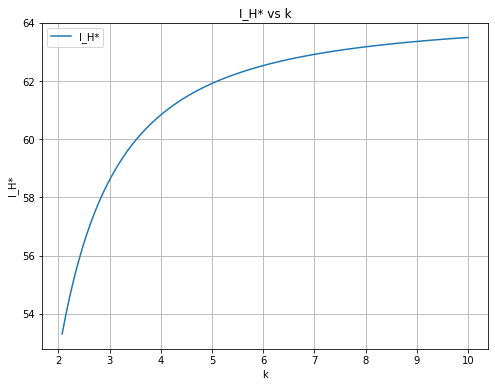

In [32]:
plt.figure(figsize=(8, 6))

plt.plot(k_values, equilibrium_full_values, label='I_H*')
plt.xlabel('k')
plt.ylabel('I_H*')
plt.title('I_H* vs k')

plt.legend()
plt.grid(True)

plt.show() 

Equilíbrio endêmico de humanos infectados quando $I_H^* \geq 0:$

In [33]:
k_values = np.linspace(0.7948596924159165, 10, 100) 

equilibrium_full_values = []

for k_val in k_values:
    equilibrium_numerator_final, equilibrium_denominator_final, equilibrium_final = calculate_equilibrium_final_values(N, R_L, T_linha, Tmin, DD, D1, 
                                                                               T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                               p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, 
                                                                               gamma, mu_H, k=k_val)
    equilibrium_full_values.append(equilibrium_final)

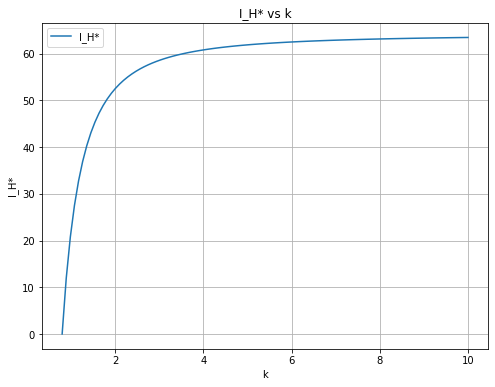

In [34]:
plt.figure(figsize=(8, 6))

plt.plot(k_values, equilibrium_full_values, label='I_H*')
plt.xlabel('k')
plt.ylabel('I_H*')
plt.title('I_H* vs k')

plt.legend()
plt.grid(True)

plt.show() 